We'll demonstrate here another major advantage of this package: The ability to simply and quickly extract cluster transitions from a clustered time series. These transitions are called crossings.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from clustervisualizer.ClusterAnalyzer import ClusterAnalyzer as clust

from sklearn.cluster import KMeans

Toy datasets for clustering purposes that involve a time series are rare... so we've created a toy simulator. In it, a detector bounces around a box while making temperature measurements of different gases. In the hard temperature boundary simulation, there are only two regions: a high temperature gas and a low temperature one. If the detector is to the left of this hard boundary, it measures the low temp gas; if it's to the right, it measures the high temp gas. 

These temperature measurements are simulated by sampling from the corresponding normal distribution. The low temp gas distribution has low mean and low standard deviation and the high temp one has high mean and moderate standard deviation. This way, the measurements it records in these regions will reflect their sampled distributions.

This simulator is a class and can be imported from the subfolder 'example' of the clustervisualizer package 

In [12]:
from clustervisualizer.examples.simulate_detector \
        import simulate_detector as sim

Let's instantiate it and study the detector's measurements. For our purposes, we only need to be aware of three of its functions: start(), plot_trajectory(), and get_data().

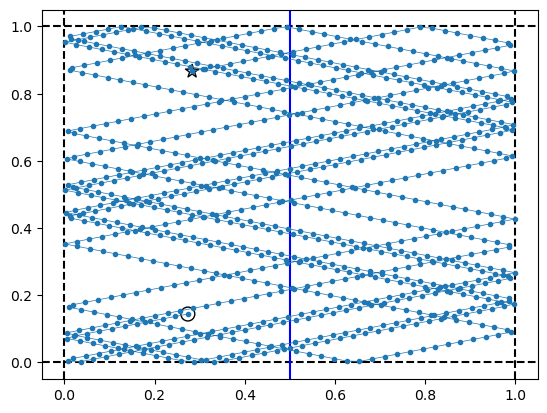

In [18]:
# instantiate
_sim = sim(max_iter=10**3)

# begin sim
_sim.start()

# show path of detector around box
_sim.plot_trajectory()

Plenty of stuff going on here...

    (1) The black dashed outer boundaries indicate the bounds of the box,
    (2) the thick centered blue line is the hard temperature boundary,
    (3) the blue dots indicate positions of the detector at time steps,
    (4) the thin blue lines show the *consecutive* motion of the detector,
    (5) the hollow black circle shows the starting position of the detector,
    (6) the hollow black start is the detector's last position.

When ran to max_iter=N, the detector has 3 types of relevant data: its position (2xN array), its velocity (2xN array) and a temperature measurement (N). This can all be retrieved as a pandas dataframe using the get_data() function.

['x', 'y', 'vx', 'vy', 'temp']


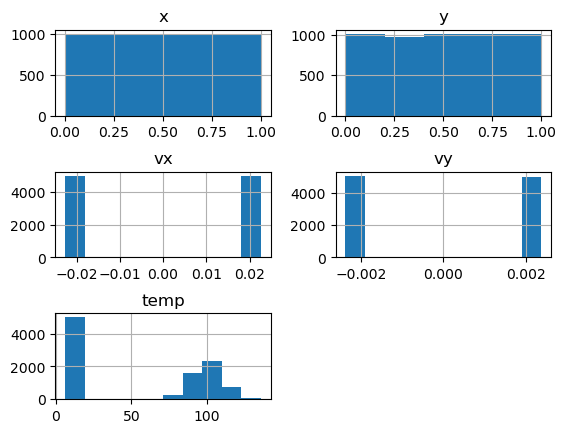

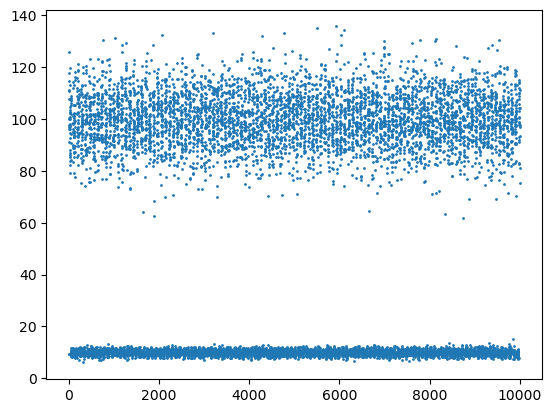

In [14]:
X = _sim.get_data()
print( list(X) )

# Make hist of detector data
axes = X.hist()
plt.subplots_adjust(hspace=0.65)
plt.show()
plt.close()

# study 'time' series of detector
plt.scatter( np.arange(X.shape[0]), X['temp'], s=1 )
plt.show()
plt.close()

Some observations:

(1) This simulator is crude, and just uses a simple velocity inversion (multiplied by -1) if the detector were to leave the bounds of the box. So that's why there are just two columns in the VX and VY histograms. 

(2) Its very apparent that the detector has sampled from two distributions for its temperature measurements, both from the histogram and the time series.

But anyways, we've now created some simple 1d clustering data! Uncovering the cluster transitions (called 'crossings') from the data requires the time data type to be a Pandas timestamp object, so we'll assign some artifical time range as the data.

In [15]:
# This will create a range of timestamps starting at Jan 1 2008 00:00:00 with a frequency of 1 minute.
# It will count out to however large our dataframe object is.
X['time'] = pd.date_range(start='2008-01-01',
                          freq='1 min',
                          periods=X.shape[0])

Now let's cluster the temperature measurements using KMeans

In [16]:
_kmeans = KMeans(n_clusters=2, random_state=1)
preds = _kmeans.fit_predict( X['temp'].values.reshape(-1,1) )

With cluster predictions, we can instantiate a ClusterAnalyzer object and study the results

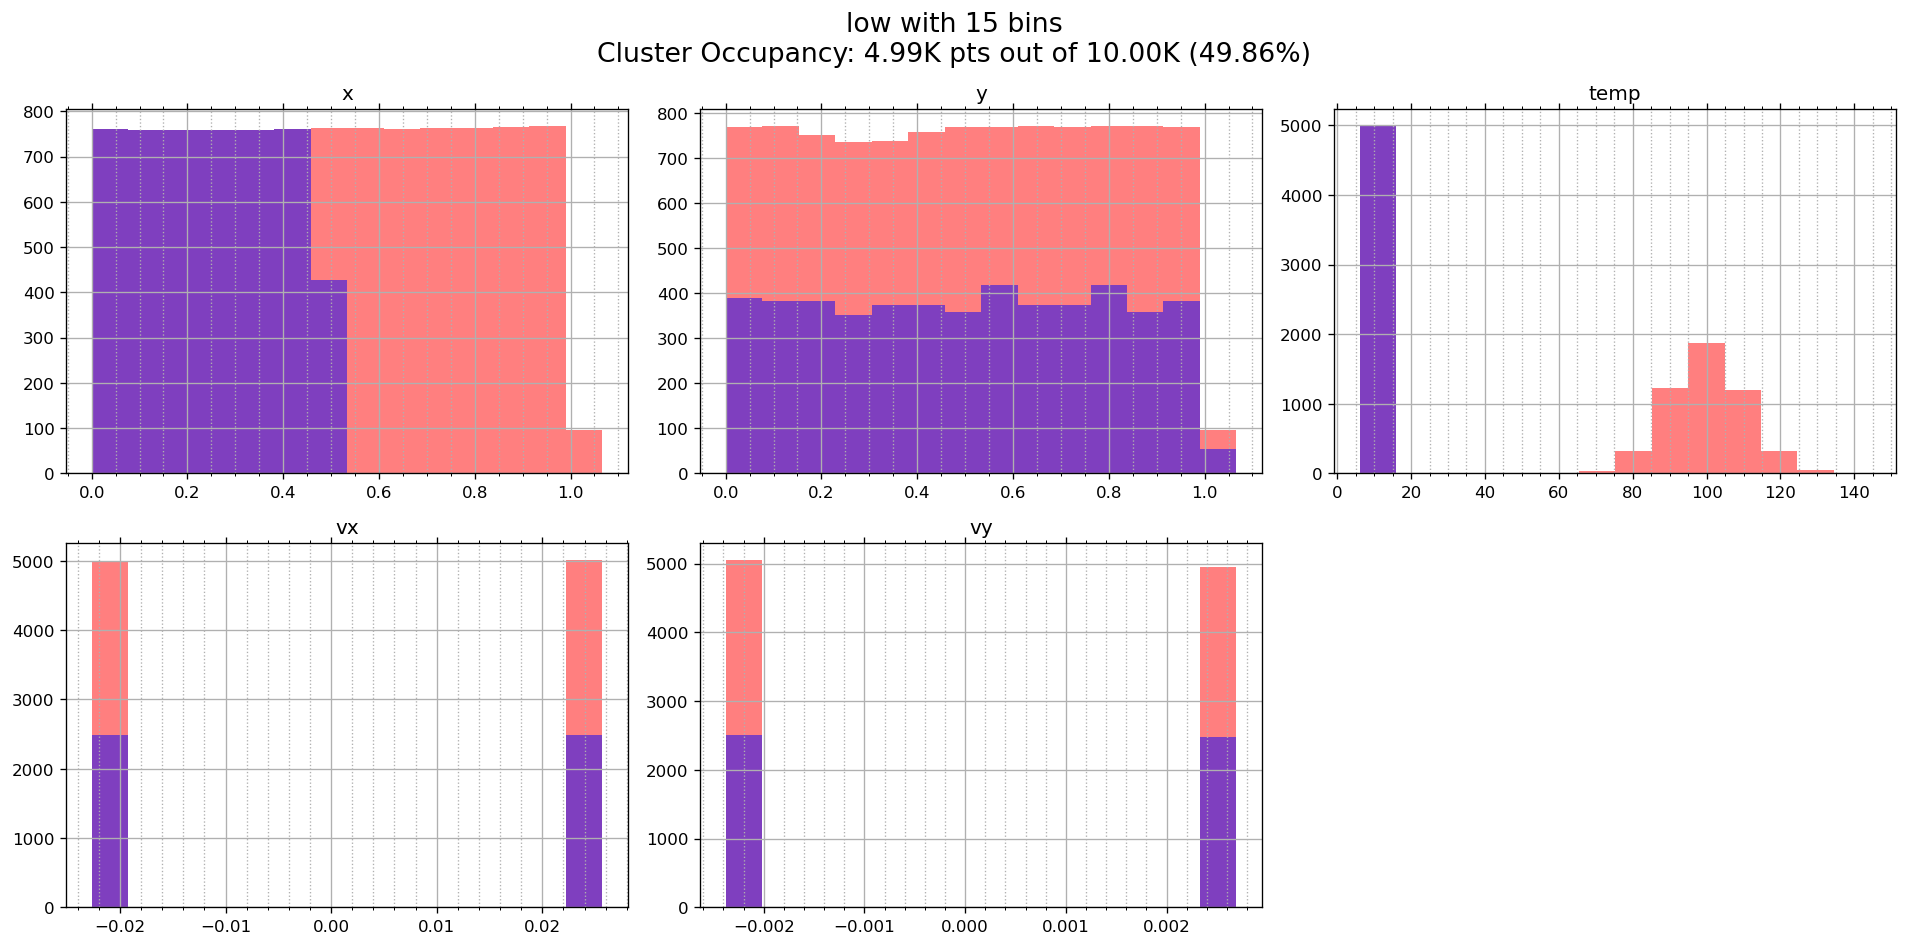

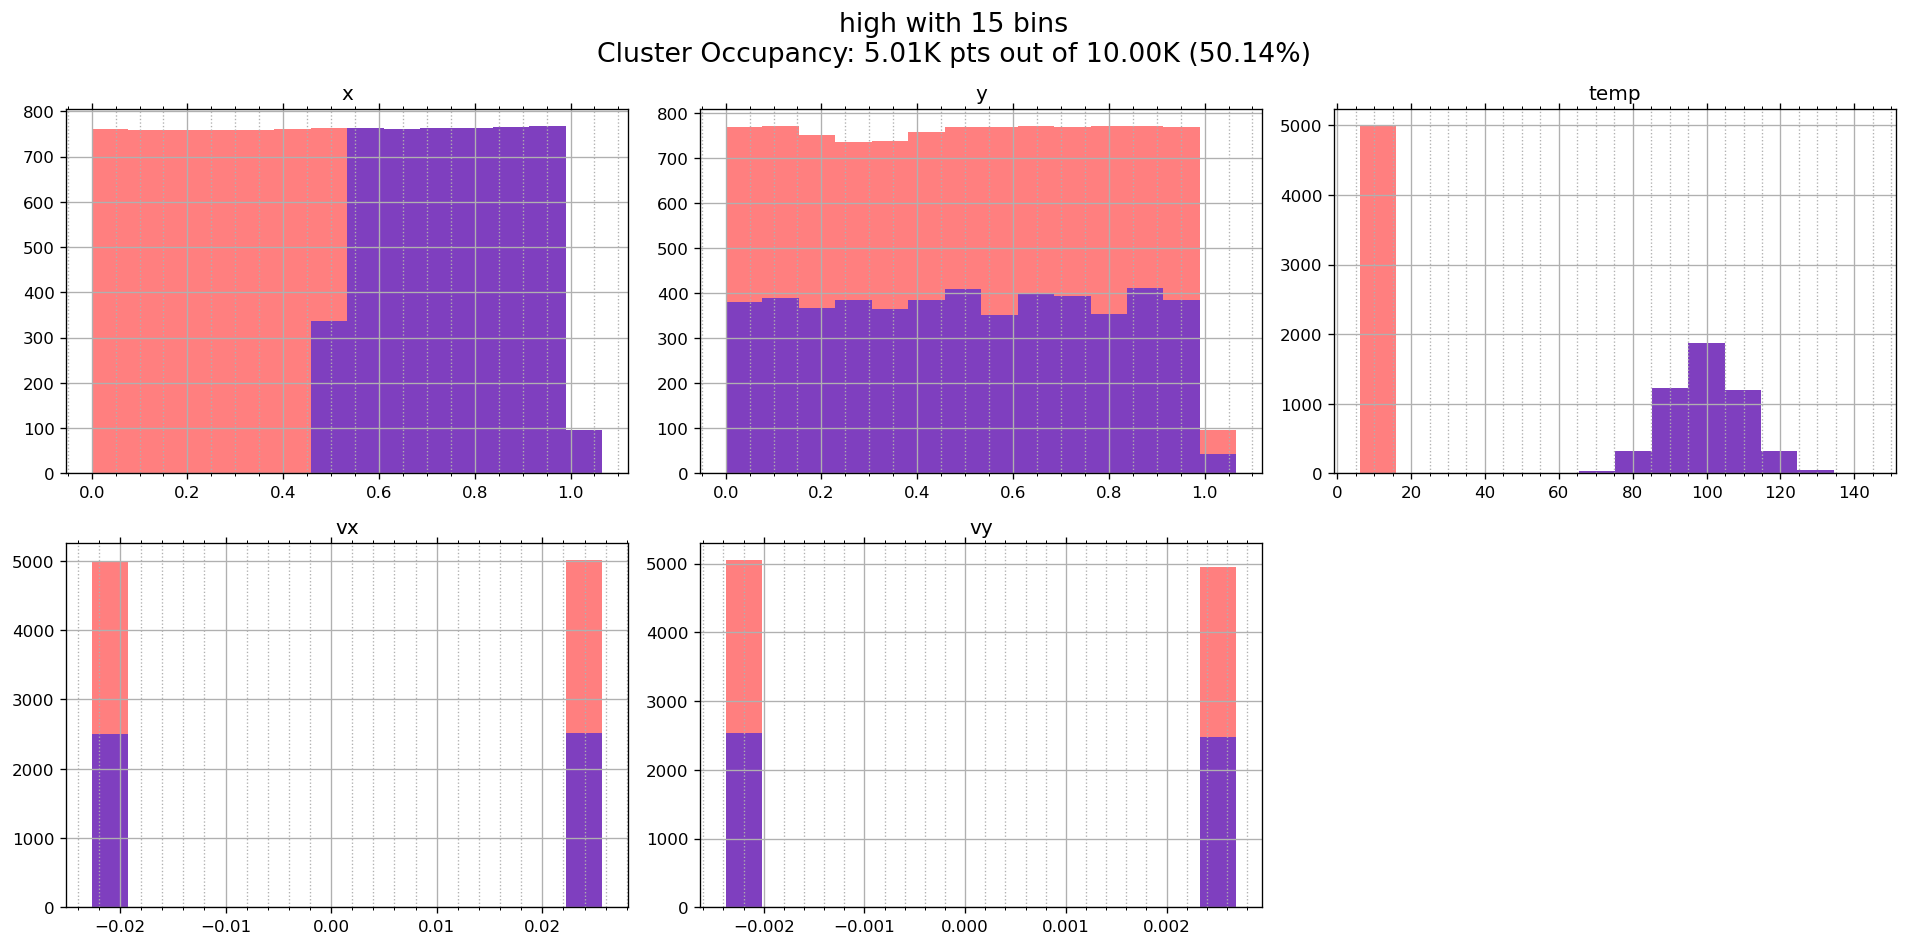

In [17]:
names = {
    'high' : 'temp',
            # the cluster with highest avg temp will be the high temp gas ...
    'low'  : ('temp', lambda x: -1*np.mean(x))
            # ... and the one with lowest avg temp will be the low temp gas
        }
_clust = clust(X, preds,
               name_clusters=names)

hist_vars = ['x','y','temp','vx','vy']
_clust.hist1d(bins=15,
              hist_vars=hist_vars)

As expected, the clustering works very well. Looking at the histograms, one could imagine that perhaps there are some "low" temperature measurements that fall into the higher temp distribution, but there are so few of them that they're hard to see. We can look at the log scale of the histogram for the 'temp' feature to see if this is the case using the 'logy' named argument.

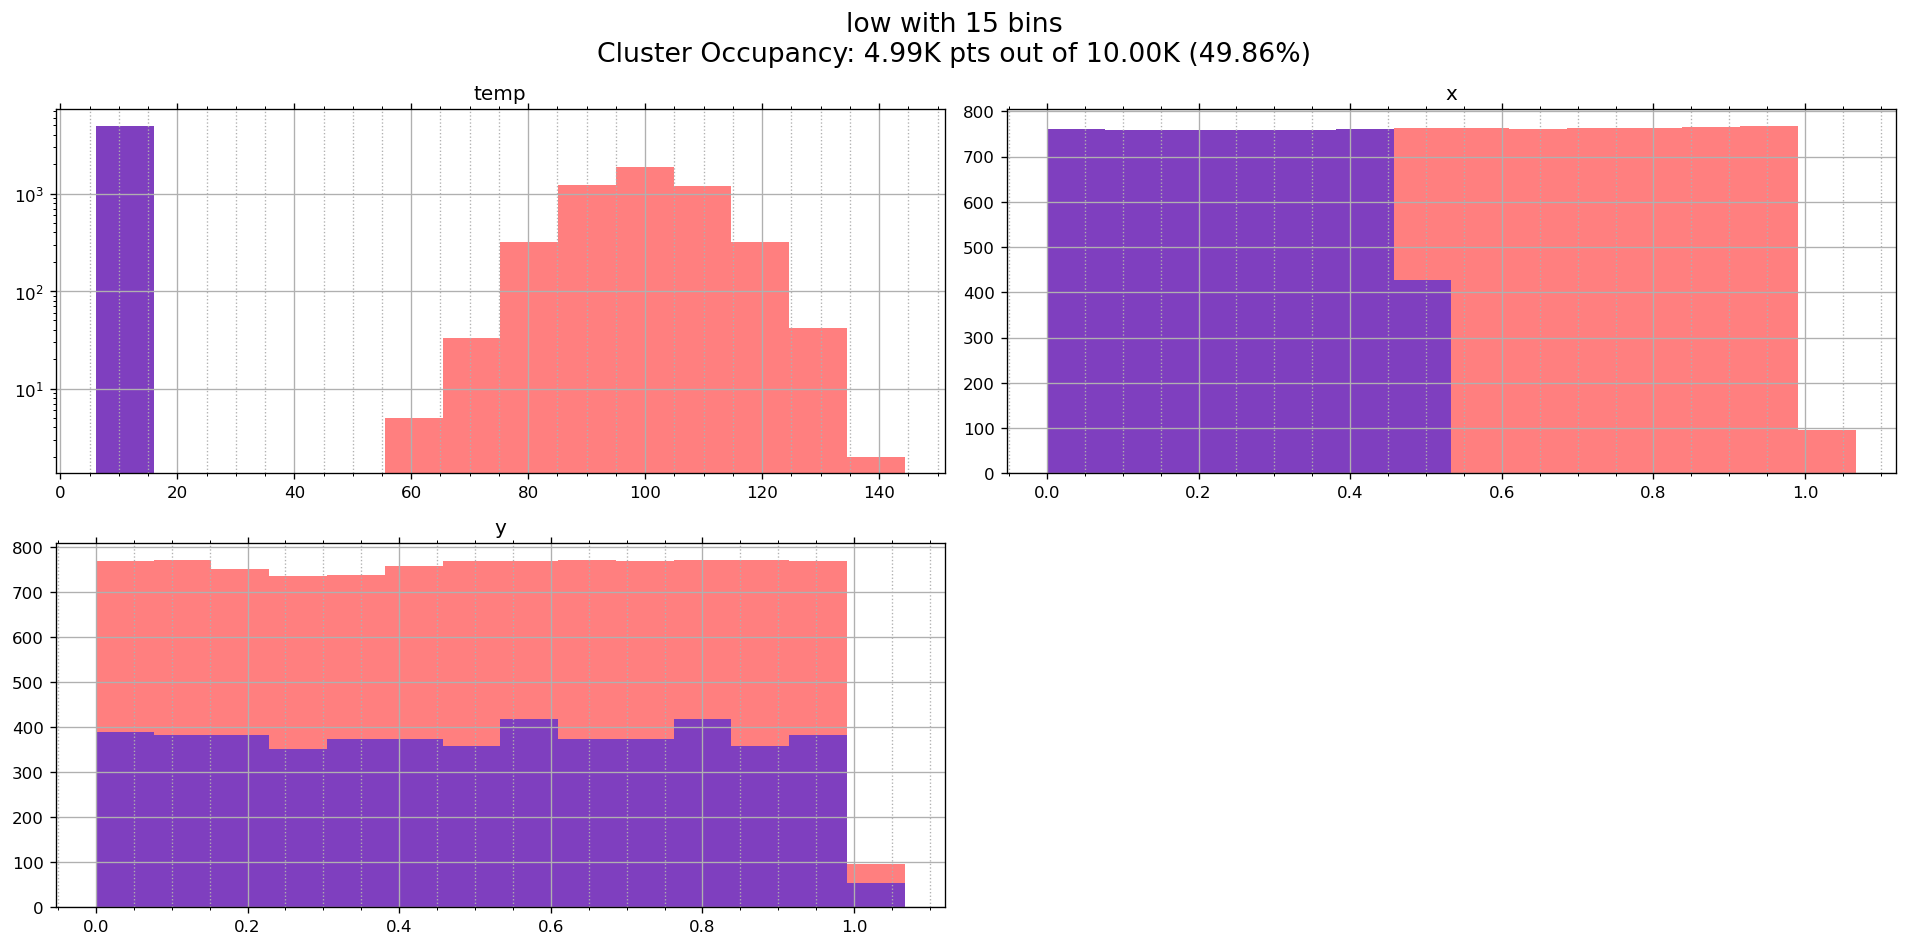

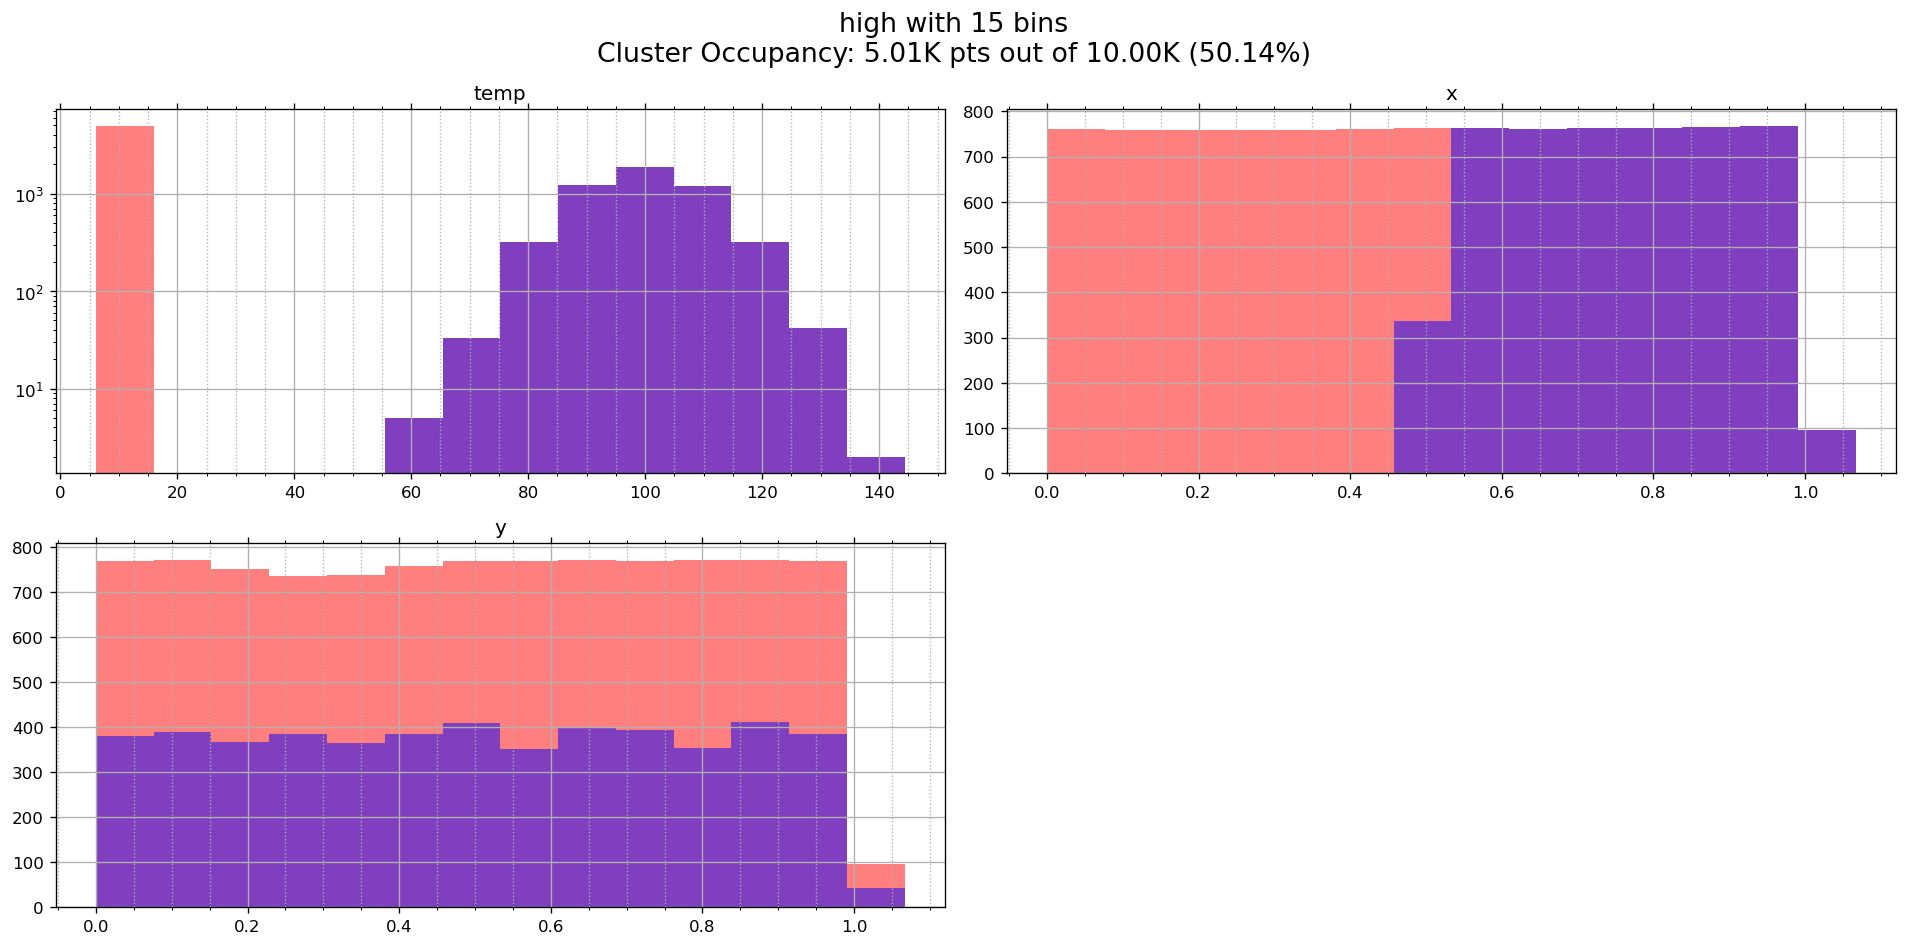

In [63]:
_clust.hist1d(
            bins=15,
            hist_vars=['temp','x','y'],
            logy='temp'
                #  can be True (all are set to logy), a str (logy for only that label),
                #  or list of str (logy for all labels in list)
             )

We can extract the crossings from the data using the compute_crossings function. This takes a set of mandatory named arguments in order to work and can be best explained with an accompanying diagram.

    ---------- DIAGRAM ----------

    prediction-
       axis
        || * * * * * * * * * * o o o o o o o o o o 
        || |         |       | |         |       |    
        || |         |       | |         |       |
      ==||=|=========|=======|=|=========|=======|= time-axis
        || X         |       A B         |       Y
        ||           Q                   W
               
                   * - cluster 1 assignment (class 0 or 1)
                   o - cluster 2 assignment (class 0 or 1) 




At minimum, the necessary named arguments are:

    ---------- MANDATORY NAMED ARGUMENTS ----------
    
    (1) time_var (str):
            the label of the class dataframe containined the pandas timestamp data
            
    (2) min_crossing_duration (pandas time delta):
            Not currently used - give any pandas time delta value; will not
                affect results.
            
    (3) max_crossing_duration (pandas time delta):
            The max amount of time allowed for a crossing.
            In the diagram, this means a candidate crossing in data would be discarded
                if the time interval (A,B) exceeds this value
                
    (4) min_beyond_crossing_duration (pandas time delta):
            The min amount of time before / after a crossing point to track to (and
                points included this way will be used to compute if the crossing is valid)
            In the diagram, this creates the intervals (Q,A) and (B,W). 
            If the fraction of points in the intervals (Q,A) / (B,W) matching the
                cluster of the starting / ending crossing point falls below 
                below the value given by 'min_cluster_frac', then multiple different
                options may be performed depending on the value of 'overlap_preference'.
                
    (5) max_beyond_crossing_duration (pandas time delta):
            The max amount of time before / after a crossing point to track to.
            In the diagram, this creates the intervals (X,A) and (B,Y).
            The points included in the intervals (X,Q) and (W,Y) WILL NOT BE USED
                to determine if the candidate crossing is valid.



There are also additional argument that have default values if they are not explicitly set:

    ---------- ADDITIONAL NAMED ARGUMENTS (THAT ARE RELEVANT) ----------

    min_cluster_frac (float - default 0.8):
        The percentage of data in an interval that must match its crossing point. 
            That is, the fraction of points in interval (Q,A) that must match the cluster
            of point A and the fraction of points in interval (B,W) that must match the
            cluster of point B.
            
    overlap_preference (str - default 'best'):
        Determines what to do when you have overlapping crossings:
            'best': Choose the crossing with highest cluster_fraction
            'latest': Save the latest-occuring crossing
            'earliest': Save the earliest-occuring crossing
            'remove': Discard all overlapping crossings
            
    order_matters (bool - default True):
        If True, the order in which a crossing occurs matters i.e. a crossing from
            cluster A to B is distinct from B to A. If False, there is no distinction.
            
    constraints (str, list of strs / dicts):
        Used to separate data into groups, and crossings will be processed for
            each group.
        If str, then data will be separated over all unique values for this label
        If list of strs, then data will be separated over all *combinations* of 
            the unique values for these labels
        If dicts are in list, then dict should have a label as key and
            data values under that label as values (either as str or list of str)
            
The returned values from this function will be a dict with 2-element tuples as keys and dataframes as values. The tuples indicate starting and ending clusters in the crossings, and each dataframe is an individual crossing.

In [49]:
# we set a time step resolution of 1 minute, so let's pick ...
#   (1) 5 minutes for min_crossing_duration
#   (2) 5 minutes for min_beyond_crossing_duration
#   (3) 10 minutes for max_beyond_crossing_duration
cross_dict = _clust.compute_crossings(
                time_var='time',
                min_crossing_duration = pd.Timedelta('1 min'),
                max_crossing_duration = pd.Timedelta('5 min'),
                min_beyond_crossing_duration = pd.Timedelta('5 min'),
                max_beyond_crossing_duration = pd.Timedelta('10 min'),
                min_cluster_frac = 0.8,
                order_matters = False
                                      )

# print out some info about the crossigns
for key in cross_dict:
    num = len( np.unique( cross_dict[key]['crossing_num'] ) )
    print(key,'has',num,'crossings')
    if num > 0:
        print('sample crossings:')
        print( cross_dict[key][:10] )

Computing crossings under constraints:
   None
('high', 'low') has 227 crossings
sample crossings:
          x         y        vx        vy        temp                time  \
0  0.464348  0.409045  0.022668  0.002377    9.456901 2008-01-01 00:00:00   
1  0.487016  0.411422  0.022668  0.002377    9.540780 2008-01-01 00:01:00   
2  0.509685  0.413800  0.022668  0.002377  111.171313 2008-01-01 00:02:00   
3  0.532353  0.416177  0.022668  0.002377  100.303170 2008-01-01 00:03:00   
4  0.555022  0.418554  0.022668  0.002377   97.776385 2008-01-01 00:04:00   
5  0.577690  0.420931  0.022668  0.002377   97.044580 2008-01-01 00:05:00   
6  0.600359  0.423308  0.022668  0.002377  110.830862 2008-01-01 00:06:00   
7  0.623027  0.425686  0.022668  0.002377   91.051449 2008-01-01 00:07:00   
8  0.645696  0.428063  0.022668  0.002377  107.567520 2008-01-01 00:08:00   
9  0.668364  0.430440  0.022668  0.002377  114.519382 2008-01-01 00:09:00   

   crossing_points  crossing_num  high  low  
0      

Data in this raw form is hard to interpret... but this is what the CrossingAnalyzer class is for! We can import this class from the clustervisualizer package.

In [ ]:
from clustervisualizer.CrossingAnalyzer import CrossingAnalyzer as cross

We can name the cluster crossings using a dict with the constructor to simplify how they're referred to.

In [34]:
# determine which was crossings were recorded - either ('high','low') or reverse
# depending on simulator data
name_tuple = ('high','low') if ('high','low') in cross_dict else ('low','high')
cross_names = { name_tuple : 'foo' }

# instantiate
_cross = cross(cross_dict,
               crossing_names=cross_names)

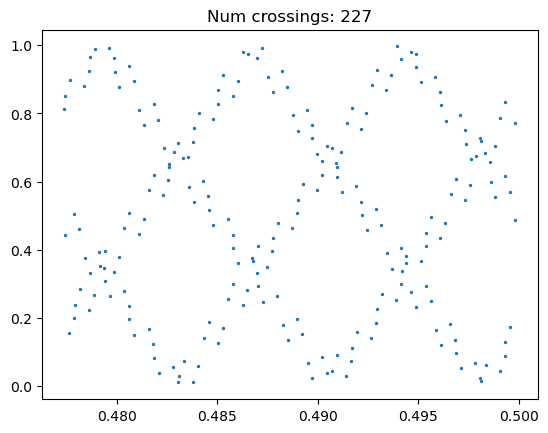

In [51]:
_cross.plot_crossings(
        crossing='foo',
            #  the crossing type to plot
        x='x', y='y',
            #  x and y labels of data in the crossing dataframes to plot
        cluster='low'
            #  which cluster-side of the crossing to plot
            # (if not set, will plot *both* sides, i.e. both 'high' and 'low', so 2 pts per crossing!)
                     )

At first, this is a little strange to interpret. Jupyter Notebook has some issues with replotting figures due to how Matplotlib is accessed, so we'll have to retrieve the data manually to replot it. We can use the get_crossigns_dfs_as_list function to do just that: 

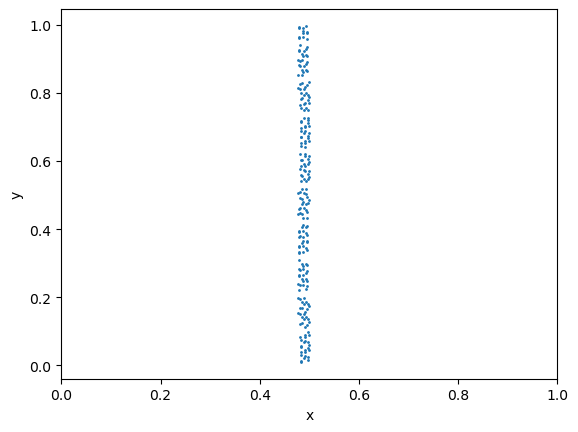

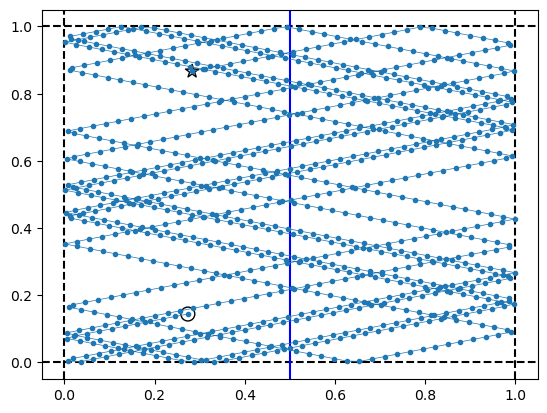

In [62]:
cross_df = _cross.get_crossing_dfs_as_list(
                crossing='foo',
                cluster='low',
                    # which cluster of the crossing should be retrieved
                point_type='immediate',
                    # determines which interval of data to retrieve...
                    #  'immediate' --> (A,B)
                    #  'normal' -----> (Q,W)
                    #  'extended' ---> (X,Y)
                single_df=True
                    # if False, returns all data as a list of dataframes; True concats them
                                            )


# plot the x,y crossing data and detector trajectory side-by-side
ax = cross_df.plot.scatter('x', 'y', s=1)
ax.set_xlim(0,1)
_sim.plot_trajectory()

That's a lot clearer! The crossings were successfully extracted and have caught all the times that the detector crossed the boundary.

As one final demonstration, it can be shown that ClusterAnalyzer can handle processing crossings for separate chunks of data. Let's run multiple detector simulations, combine them, and show that they results can be cleanly depicted

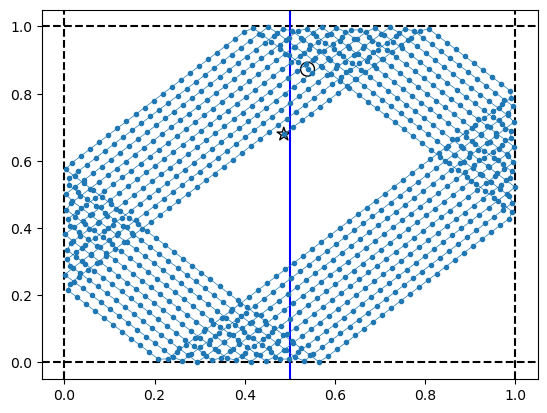

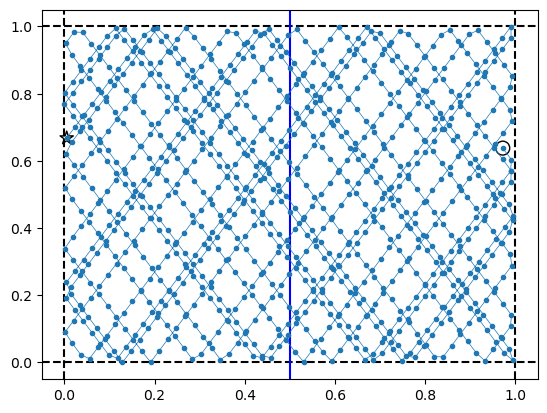

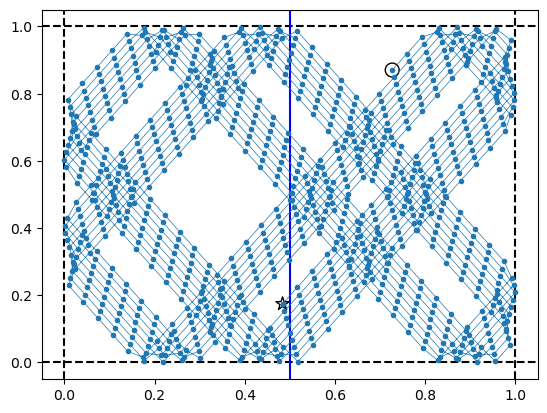

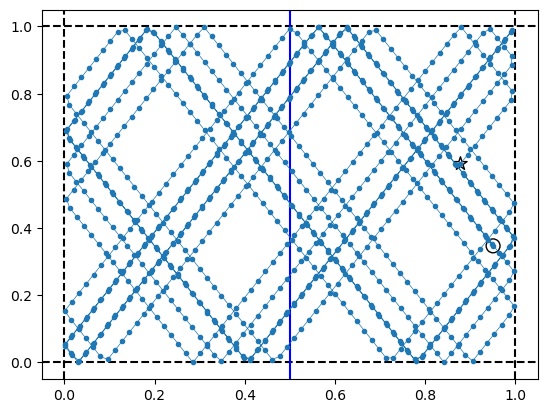

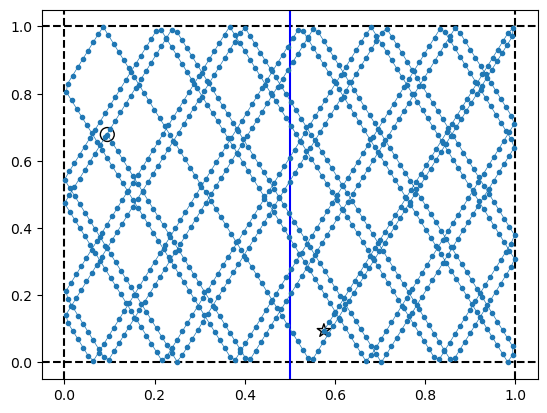

['x', 'y', 'vx', 'vy', 'temp', 'time', 'id']


<AxesSubplot: xlabel='x', ylabel='y'>

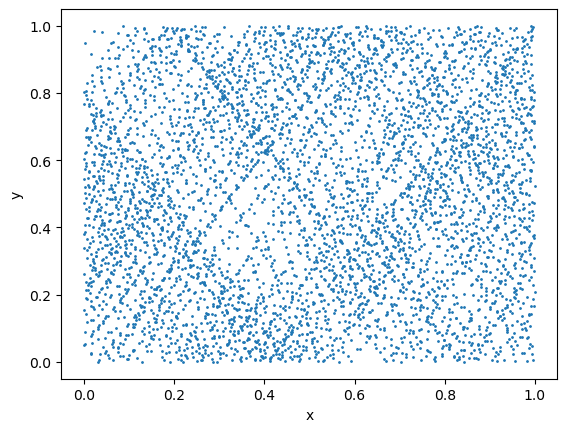

In [70]:
def run_detectors(n, detector_kwargs, plot=None):
    if plot is None: plot = False
    
    # intialize all detectors 
    det_dict = { 'det'+str(i) : sim(**detector_kwargs) for i in range(n) }
    
    df_list = []
    for det_key in det_dict:
        # get detector
        det = det_dict[det_key]
        # run sim and get data
        det.start()
        det_df = det.get_data()
        # add fake time data to each detector
        det_df['time'] = pd.date_range(start='2008-01-01',
                                       freq='1 min',
                                       periods=det_df.shape[0])
        # save detector id and data
        det_df['id'] = det_key
        df_list.append( det_df )
        # if specified, plot trajectory
        if plot: det.plot_trajectory()
        
    return det_dict, pd.concat(df_list)



detector_kwargs = {'max_iter':10**3}
detector_dict, data = run_detectors(5, detector_kwargs, plot=True)


print( list(data) )


data.plot.scatter('x', 'y', s=1)

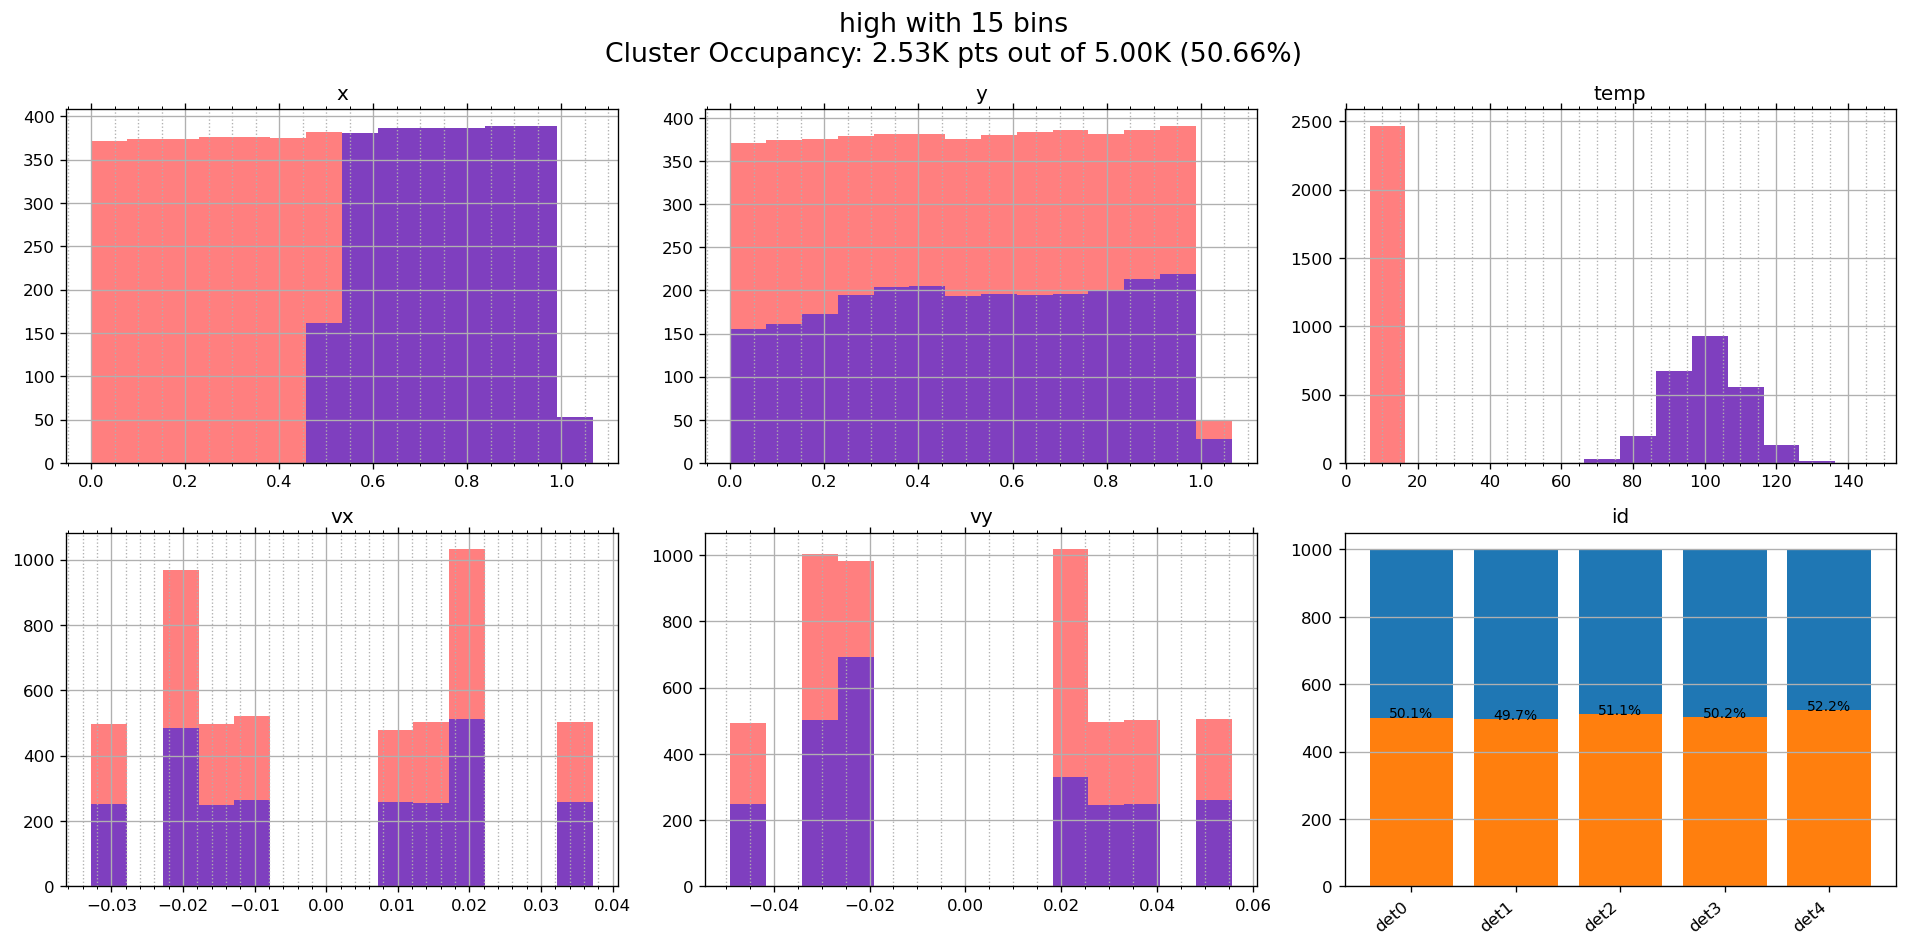

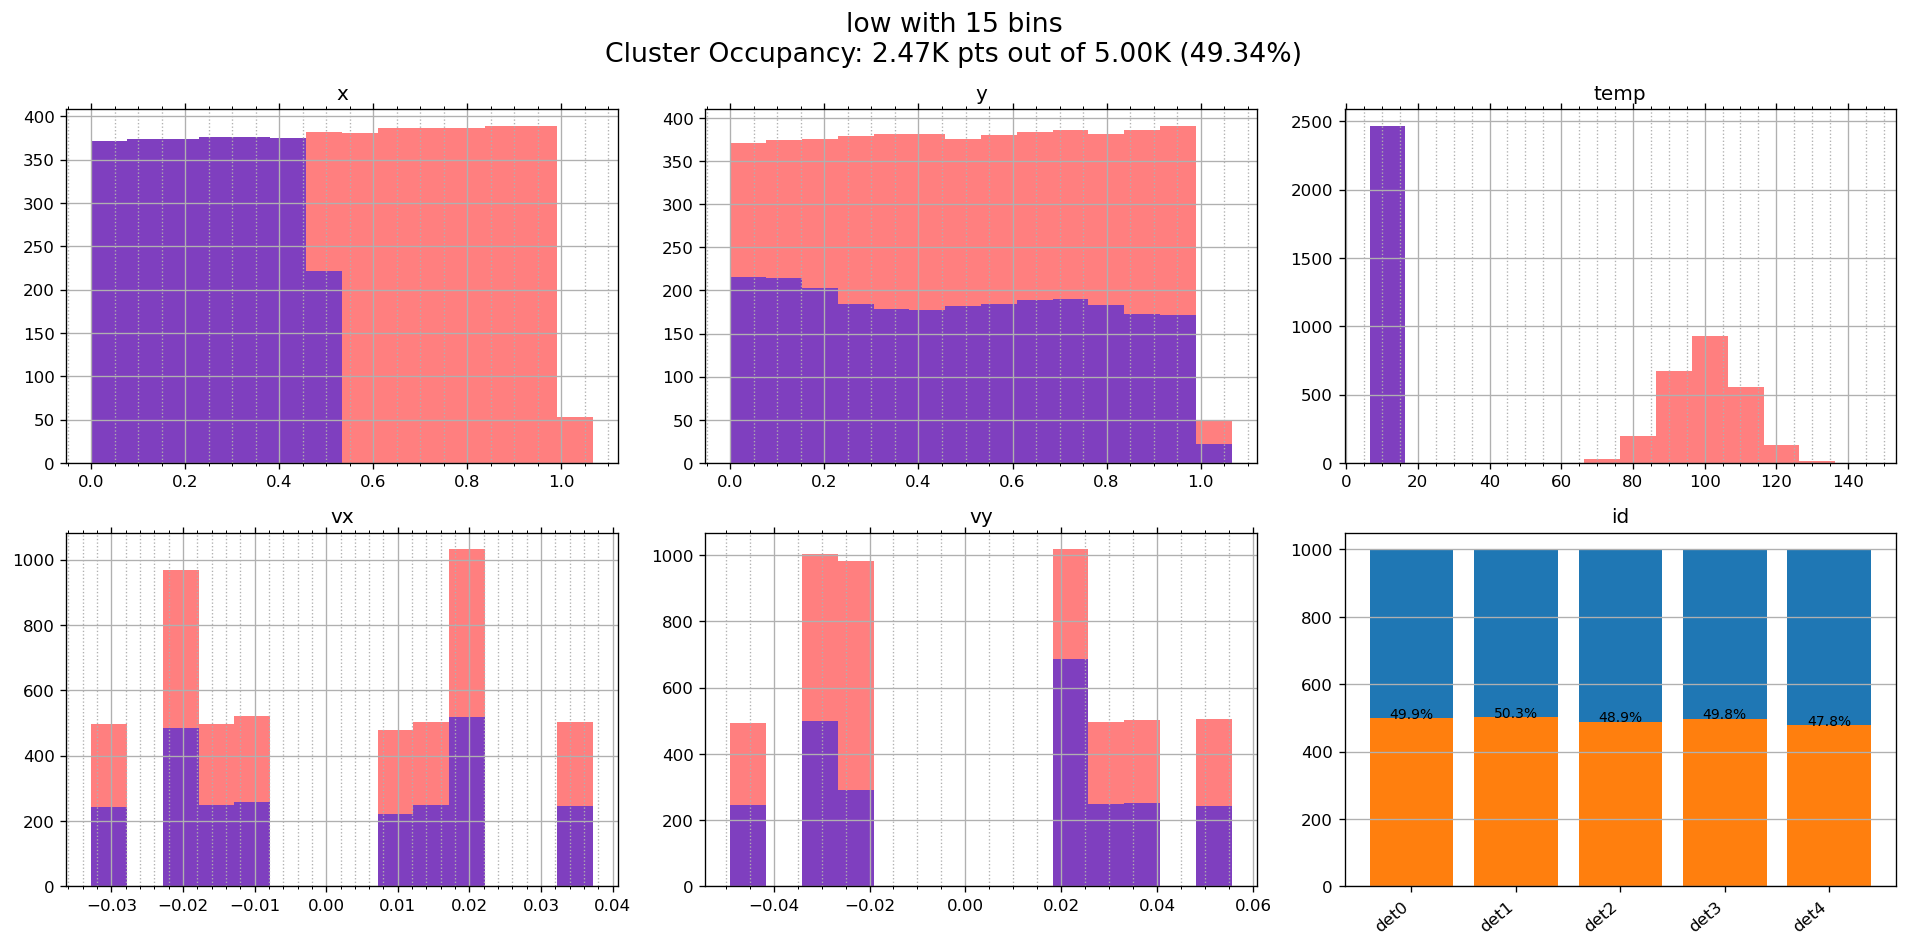

In [71]:
# cluster data
_kmeans = KMeans(n_clusters=2, random_state=1)
preds = _kmeans.fit_predict( data['temp'].values.reshape(-1,1) )

# init ClusterAnalyzer
new_clust = clust(data, preds,
                  name_clusters=names)

# make hists
new_clust.hist1d(bins=15, hist_vars=[*hist_vars, 'id'])

In [78]:
cross_dict = new_clust.compute_crossings(
                time_var='time',
                constraints = 'id',
                    # this will separate the data by values of this label
                    # crossings will be computed separately for all n detectors, then
                    # recombined into single dataframes 
                min_crossing_duration = pd.Timedelta('1 min'),
                max_crossing_duration = pd.Timedelta('5 min'),
                min_beyond_crossing_duration = pd.Timedelta('5 min'),
                max_beyond_crossing_duration = pd.Timedelta('10 min'),
                min_cluster_frac = 0.8,
                order_matters = False
                                         )

for key in cross_dict:
    print(key,'has',
          np.unique( cross_dict[key]['crossing_num'] ).shape[0],
          'crossings')

Computing crossings under constraints:
   {'id': 'det0'}
   {'id': 'det1'}
   {'id': 'det2'}
   {'id': 'det3'}
   {'id': 'det4'}


/home/jedmond/anaconda3/envs/clustering/lib/python3.10/site-packages/clustervisualizer/ClusterAnalyzer/utils.py:214: RuntimeWarning: invalid value encountered in long_scalars
  return num_in_cluster / (dom_clusters_over_qa.shape[0] - 1)
/home/jedmond/anaconda3/envs/clustering/lib/python3.10/site-packages/clustervisualizer/ClusterAnalyzer/utils.py:214: RuntimeWarning: invalid value encountered in long_scalars
  return num_in_cluster / (dom_clusters_over_qa.shape[0] - 1)
/home/jedmond/anaconda3/envs/clustering/lib/python3.10/site-packages/clustervisualizer/ClusterAnalyzer/utils.py:214: RuntimeWarning: invalid value encountered in long_scalars
  return num_in_cluster / (dom_clusters_over_qa.shape[0] - 1)
/home/jedmond/anaconda3/envs/clustering/lib/python3.10/site-packages/clustervisualizer/ClusterAnalyzer/utils.py:214: RuntimeWarning: invalid value encountered in long_scalars
  return num_in_cluster / (dom_clusters_over_qa.shape[0] - 1)
/home/jedmond/anaconda3/envs/clustering/lib/python3.

('high', 'low') has 100 crossings
('high', 'high') has 0 crossings
('low', 'low') has 0 crossings


           x         y        vx        vy       temp                time  \
0   0.489711  0.276825 -0.020073 -0.020468   9.097447 2008-01-01 00:51:00   
1   0.493850  0.726120  0.020073  0.020468   9.830042 2008-01-01 01:40:00   
2   0.482444  0.229998 -0.020073 -0.020468  10.602176 2008-01-01 02:31:00   
3   0.481044  0.752479  0.020073  0.020468  10.515597 2008-01-01 03:19:00   
4   0.495249  0.203639 -0.020073 -0.020468   9.342447 2008-01-01 04:10:00   
..       ...       ...       ...       ...        ...                 ...   
95  0.385972  0.292438 -0.011341 -0.024609   8.887115 2008-01-01 13:17:00   
96  0.192403  0.962601  0.011341  0.024609  10.277844 2008-01-01 14:08:00   
97  0.748098  0.168423  0.011341  0.024609  83.705685 2008-01-01 14:57:00   
98  0.673527  0.576538 -0.011341 -0.024609  92.321200 2008-01-01 15:48:00   
99  0.117833  0.629284 -0.011341  0.024609  11.041335 2008-01-01 16:37:00   

      id  crossing_points  crossing_num  high  low  
0   det0              

(0.0, 1.0)

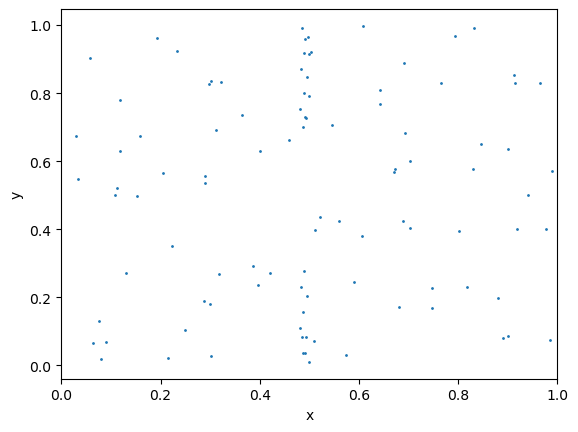

In [82]:
# init CrossingAnalyzer
new_cross = cross(cross_dict,
                  crossing_names=cross_names)

# retrieve crossing data
cross_df = new_cross.get_crossing_dfs_as_list(
                    crossing='foo',
                    cluster='low',
                    point_type='immediate',
                    single_df=True
                                              )

print(cross_df)

# scatter of retrieved crossing x,y data
ax = cross_df.plot.scatter('x', 'y', s=1)
ax.set_xlim(0,1)